Importamos librerías

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Habilitamos memory growth primero
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Ahora limitamos la memoria, en este caso a 4gb
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
            )
    except RuntimeError as e:
        print(e)

In [1]:
tf.keras.backend.clear_session()

NameError: name 'tf' is not defined

In [18]:
# Verificar GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Actualmente, solo permitir que la GPU se use en crecimiento de memoria
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Carga de datos

In [3]:
# Ruta al directorio del dataset
data_dir = 'ASL_Alph_Redim'

# Parámetros
img_height, img_width = 200, 200
batch_size = 128

# Data augmentation y preprocesamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.1, 0.9),
    fill_mode='nearest',
    validation_split=0.2  # Dividir 80% para entrenamiento y 20% para validación
)

# Crear generadores
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',   # Usar el 80% de los datos para entrenamiento
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Usar el 20% de los datos para validación
    shuffle=False
)

print(f"Cantidad en set de entrenamiento: {train_generator.samples}")
print(f"Cantidad en set de validación: {validation_generator.samples}")

Found 178472 images belonging to 29 classes.
Found 44602 images belonging to 29 classes.
Cantidad en set de entrenamiento: 178472
Cantidad en set de validación: 44602


In [4]:
train_generator.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

Desbalance de clases

In [5]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Modelo

In [6]:
def _conv_model():
  model = models.Sequential()
  # Primera capa convolucional
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(layers.MaxPooling2D())

  # Segunda capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Tercera capa convolucional
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Cuarta capa convolucional
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Quinta capa convolucional
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D())

  # Aplanamiento y capas densas
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))  # Previene sobreajuste
  model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

  return model

Instanciamos el modelo

In [7]:
model = _conv_model()

Lo compilamos

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Lo ajustamos

In [9]:
history = model.fit(
    train_generator,
    class_weight=class_weights,
    epochs=15,
    validation_data=validation_generator,
)

Epoch 1/15
1395/1395 [==============================] - 1937s 1s/step - loss: 2.3354 - accuracy: 0.2866 - val_loss: 1.6745 - val_accuracy: 0.5330
Epoch 2/15
1395/1395 [==============================] - 1680s 1s/step - loss: 1.2401 - accuracy: 0.5906 - val_loss: 1.4751 - val_accuracy: 0.6384
Epoch 3/15
1395/1395 [==============================] - 1657s 1s/step - loss: 0.9297 - accuracy: 0.6896 - val_loss: 1.3477 - val_accuracy: 0.6732
Epoch 4/15
1395/1395 [==============================] - 1602s 1s/step - loss: 0.7741 - accuracy: 0.7431 - val_loss: 1.2913 - val_accuracy: 0.7092
Epoch 5/15
1395/1395 [==============================] - 1572s 1s/step - loss: 0.6749 - accuracy: 0.7768 - val_loss: 1.3120 - val_accuracy: 0.6973
Epoch 6/15
1395/1395 [==============================] - 1569s 1s/step - loss: 0.6083 - accuracy: 0.7979 - val_loss: 1.3765 - val_accuracy: 0.7219
Epoch 7/15
1395/1395 [==============================] - 1582s 1s/step - loss: 0.5582 - accuracy: 0.8142 - val_loss: 1.2617 -

Lo evaluamos

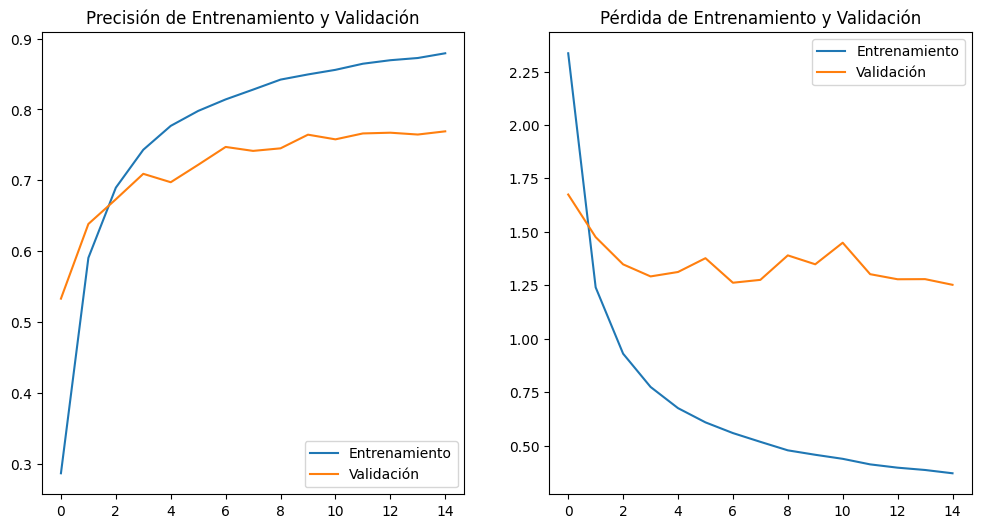

In [10]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()

Lo almacenamos

In [11]:
model.save('arq_modelo_15.h5')
model.save('arq_modelo_15.keras')

Predicciones

In [13]:
clases={'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [35]:
print(clases)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


In [ ]:
from tensorflow.keras.models import load_model

# Cargamos el modelo
model = load_model('/content/arq_modelo_11.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 [==============================] - 0s 18ms/step


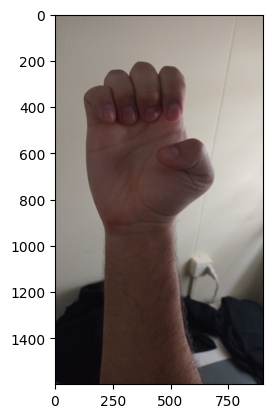

La seña predicha es: A


In [30]:
from tensorflow.keras.preprocessing import image

def predict_sign(img_path, model):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalizar
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Invertir el diccionario de class_indices
    class_indices = {v: k for k, v in clases.items()}

    # Obtener la clase predicha
    predicted_class_name = class_indices[predicted_class[0]]
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    return predicted_class_name

# Ejemplo de uso
# Asegúrate de que la ruta a tu imagen sea correcta
sign = predict_sign('Fotos/e_2.jpg', model)
print("La seña predicha es:", sign)